In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchsummary import summary

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import fbeta_score, confusion_matrix
from sklearn.model_selection import KFold

import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import gzip

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] # 修改中文字體
plt.rcParams['axes.unicode_minus'] = False # 顯示負號

# set device to gpu
device = (
"cuda"
if torch.cuda.is_available()
else "mps"
if torch.backends.mps.is_available()
else "cpu"
)
device

/Users/jim/anaconda3/envs/forDeepLearning/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'mps'

In [2]:
tfidf_train_data = pd.read_csv('../Data/TrainingData/tfidf_train.csv')
tfidf_test_data = pd.read_csv('../Data/ValidateData/tfidf_val.csv')

word2vec_train_data = pd.read_csv('../Data/TrainingData/word2vec_train.csv')
word2vec_test_data = pd.read_csv('../Data/ValidateData/word2vec_val.csv')

word2vec_selftrain_train_data = pd.read_csv('../Data/TrainingData/word2vec_selftrain_train.csv')
word2vec_selftrain_test_data = pd.read_csv('../Data/ValidateData/word2vec_selftrain_val.csv')

bert_train_data = pd.read_csv('../Data/TrainingData/bert_train.csv')
bert_test_data = pd.read_csv('../Data/ValidateData/bert_val.csv')

bert_selftrain_train_data = pd.read_csv('../Data/TrainingData/bert_selftrain_train.csv')
bert_selftrain_test_data = pd.read_csv('../Data/ValidateData/bert_selftrain_val.csv')

In [3]:
def train_mlp_model_with_f2_score(train_df, test_df, model_path, scaler_path):
    train_data = train_df.copy()
    test_data = test_df.copy()
    
    y_train = train_data.pop('source')  # 假設標籤列名為 'source'
    y_test = test_data.pop('source')  # 假設標籤列名為 'source'

    # 標準化數據
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(train_data.values)
    X_test_scaled = scaler.transform(test_data.values)
    
    # 保存標準化器
    with gzip.open(scaler_path, 'wb') as f:
        joblib.dump(scaler, f)

    # 10折交叉驗證
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    fold = 0
    confusion_matrices = []
    f2_scores = []
    best_model = None
    best_f2_score = float('-inf')

    for train_index, test_index in kf.split(X_train_scaled):
        fold += 1
        X_train, X_val = X_train_scaled[train_index], X_train_scaled[test_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        # 將數據轉換為 PyTorch 張量並移動到 GPU
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
        y_train_tensor = torch.tensor(y_train_fold.values, dtype=torch.float32).view(-1, 1).to(device)
        y_val_tensor = torch.tensor(y_val_fold.values, dtype=torch.float32).view(-1, 1).to(device)

        # 建立 MLP 模型
        input_size = X_train_tensor.shape[1]
        model = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

        summary(model, (input_size,))
        model.to(device)

        # 定義損失函數和優化器
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # 訓練模型
        num_epochs = 100
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train_tensor)
            loss = criterion(outputs, y_train_tensor)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 10 == 0:
                print(f'Fold [{fold}], Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

        # 測試模型並計算F2 score
        model.eval()
        with torch.no_grad():
            y_pred_train = model(X_train_tensor)
            y_pred_val = model(X_val_tensor)

            y_pred_train = y_pred_train.cpu().numpy()
            y_pred_val = y_pred_val.cpu().numpy()

            y_pred_train = (y_pred_train > 0.5).astype(int)
            y_pred_val = (y_pred_val > 0.5).astype(int)

            y_train_numpy = y_train_tensor.cpu().numpy()
            y_val_numpy = y_val_tensor.cpu().numpy()

            cm_train = confusion_matrix(y_train_numpy, y_pred_train)
            cm_test = confusion_matrix(y_val_numpy, y_pred_val)
            confusion_matrices.append((cm_train, cm_test))

            f2 = fbeta_score(y_val_numpy, y_pred_val, beta=2)
            f2_scores.append(f2)

            # 保存最佳模型
            if f2 > best_f2_score:
                best_f2_score = f2
                best_model = model

    # 計算平均F2-score
    avg_f2_score = sum(f2_scores) / len(f2_scores)
    print(f'Average F2 Score: {avg_f2_score:.4f}')

    # 計算混淆矩陣加總再標準化
    sum_cm_train = sum([cm[0] for cm in confusion_matrices])
    sum_cm_val = sum([cm[1] for cm in confusion_matrices])

    norm_cm_train = sum_cm_train.astype('float') / sum_cm_train.sum(axis=1)[:, np.newaxis]
    norm_cm_val = sum_cm_val.astype('float') / sum_cm_val.sum(axis=1)[:, np.newaxis]

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle('Normalized Confusion Matrices')

    sns.heatmap(norm_cm_train, annot=True, fmt='.2f', ax=axs[0], cmap='Blues')
    axs[0].set_title('Normalized Train Confusion Matrix')
    axs[0].set_xlabel('Predicted')
    axs[0].set_ylabel('Actual')

    sns.heatmap(norm_cm_val, annot=True, fmt='.2f', ax=axs[1], cmap='Blues')
    axs[1].set_title('Normalized Validation Confusion Matrix')
    axs[1].set_xlabel('Predicted')
    axs[1].set_ylabel('Actual')

    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

    # 保存最佳模型
    torch.save(best_model, model_path)

    # 評估validation set
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1).to(device)

    best_model.eval()
    with torch.no_grad():
        y_test_pred = best_model(X_test_tensor)
        y_test_pred = y_test_pred.cpu().numpy()
        y_test_pred = (y_test_pred > 0.5).astype(int)
        y_test_numpy = y_test_tensor.cpu().numpy()

        test_cm = confusion_matrix(y_test_numpy, y_test_pred)
        test_f2_score = fbeta_score(y_test_numpy, y_test_pred, beta=2)

    print(f'Test F2 Score: {test_f2_score:.4f}')

    norm_test_cm = test_cm.astype('float') / test_cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(7, 5))
    sns.heatmap(norm_test_cm, annot=True, fmt='.2f', cmap='Blues')
    plt.title('Normalized Testing Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]      38,627,328
              ReLU-2                 [-1, 1024]               0
            Linear-3                  [-1, 512]         524,800
              ReLU-4                  [-1, 512]               0
            Linear-5                  [-1, 256]         131,328
              ReLU-6                  [-1, 256]               0
            Linear-7                    [-1, 1]             257
           Sigmoid-8                    [-1, 1]               0
Total params: 39,283,713
Trainable params: 39,283,713
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.14
Forward/backward pass size (MB): 0.03
Params size (MB): 149.86
Estimated Total Size (MB): 150.03
----------------------------------------------------------------
Fold [1], Epoch [10/100], Loss: 

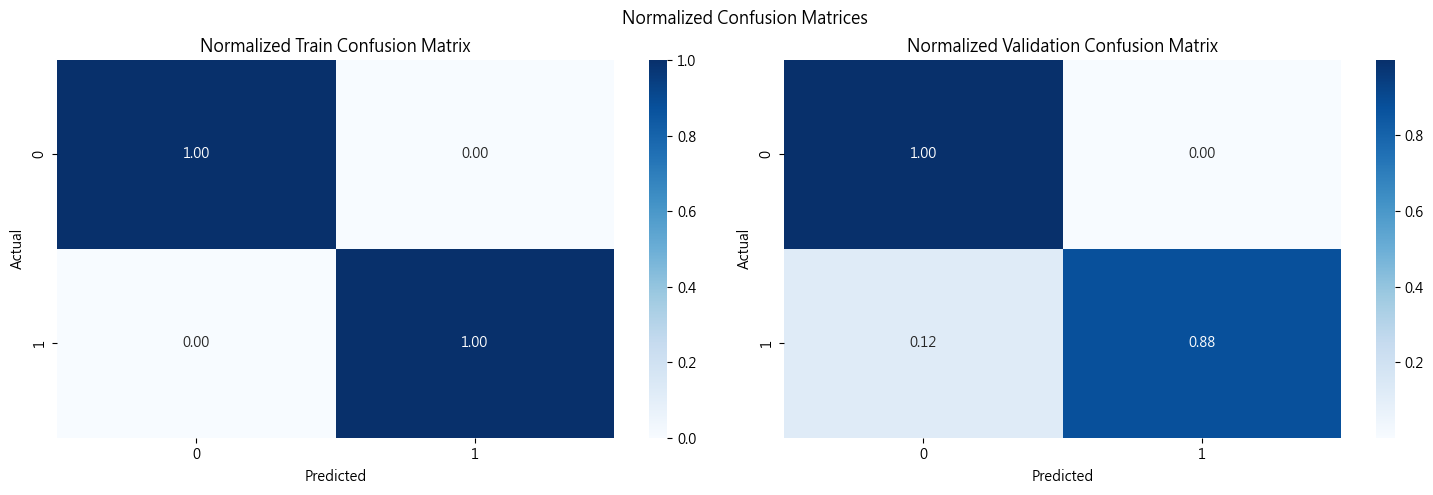

Test F2 Score: 0.9865


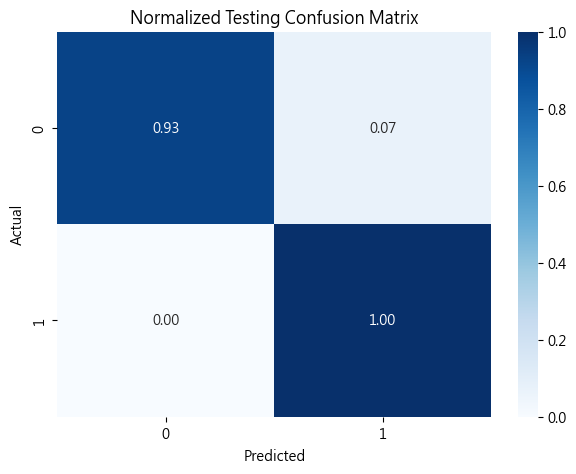

In [4]:
train_mlp_model_with_f2_score(tfidf_train_data, tfidf_test_data, '../Data/Model/tfidf_mlp_10fold_model.pth.gz', '../Data/Model/tfidf_10fold_scaler.pkl.gz')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]         103,424
              ReLU-2                 [-1, 1024]               0
            Linear-3                  [-1, 512]         524,800
              ReLU-4                  [-1, 512]               0
            Linear-5                  [-1, 256]         131,328
              ReLU-6                  [-1, 256]               0
            Linear-7                    [-1, 1]             257
           Sigmoid-8                    [-1, 1]               0
Total params: 759,809
Trainable params: 759,809
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 2.90
Estimated Total Size (MB): 2.93
----------------------------------------------------------------
Fold [1], Epoch [10/100], Loss: 0.0229
Fol

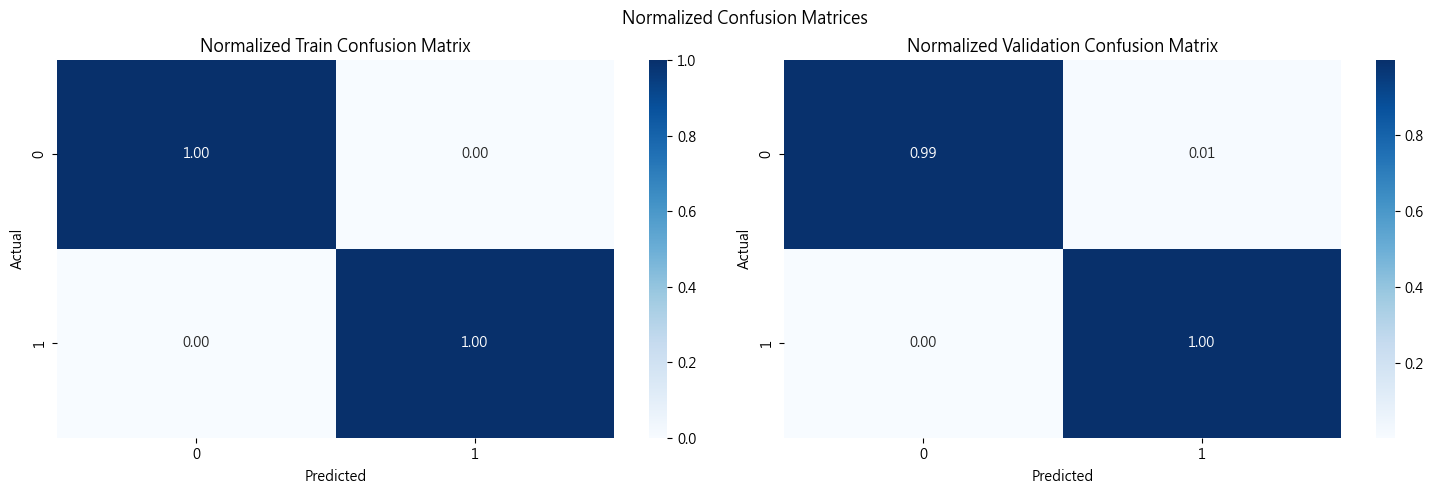

Test F2 Score: 0.9961


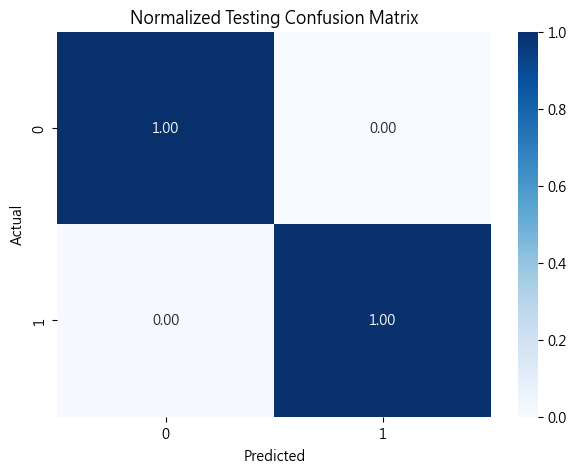

In [5]:
train_mlp_model_with_f2_score(word2vec_selftrain_train_data, word2vec_selftrain_test_data, '../Data/Model/word2vec_selftrain_mlp_10fold_model.pth.gz', '../Data/Model/word2vec_selftrain_10fold_scaler.pkl.gz')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]         103,424
              ReLU-2                 [-1, 1024]               0
            Linear-3                  [-1, 512]         524,800
              ReLU-4                  [-1, 512]               0
            Linear-5                  [-1, 256]         131,328
              ReLU-6                  [-1, 256]               0
            Linear-7                    [-1, 1]             257
           Sigmoid-8                    [-1, 1]               0
Total params: 759,809
Trainable params: 759,809
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 2.90
Estimated Total Size (MB): 2.93
----------------------------------------------------------------
Fold [1], Epoch [10/100], Loss: 0.0541
Fol

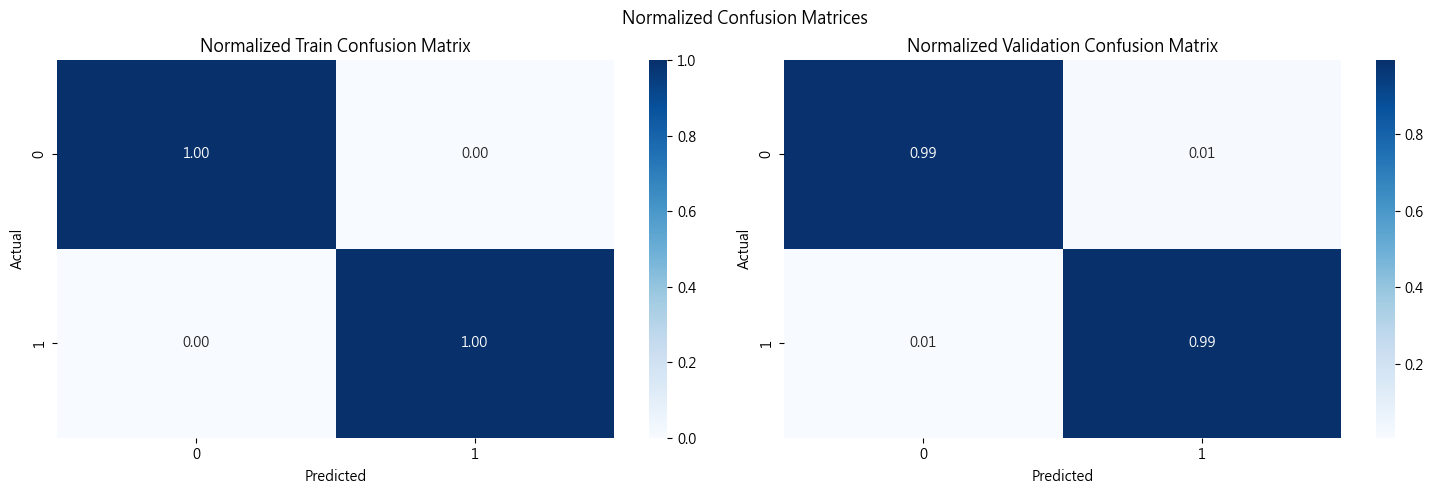

Test F2 Score: 0.9883


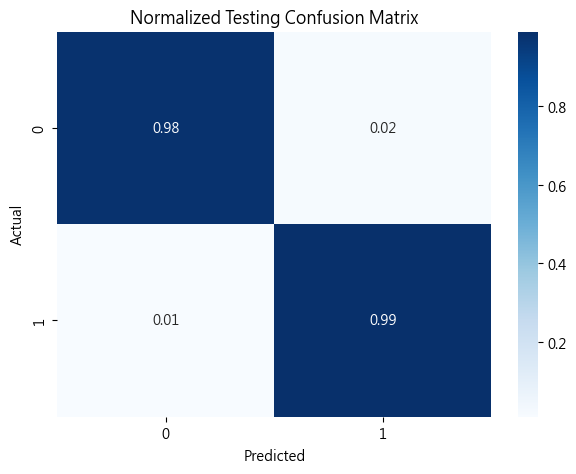

In [6]:
train_mlp_model_with_f2_score(word2vec_train_data, word2vec_test_data, '../Data/Model/word2vec_mlp_10fold_model.pth.gz', '../Data/Model/word2vec_10fold_scaler.pkl.gz')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]         787,456
              ReLU-2                 [-1, 1024]               0
            Linear-3                  [-1, 512]         524,800
              ReLU-4                  [-1, 512]               0
            Linear-5                  [-1, 256]         131,328
              ReLU-6                  [-1, 256]               0
            Linear-7                    [-1, 1]             257
           Sigmoid-8                    [-1, 1]               0
Total params: 1,443,841
Trainable params: 1,443,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 5.51
Estimated Total Size (MB): 5.54
----------------------------------------------------------------
Fold [1], Epoch [10/100], Loss: 0.0005

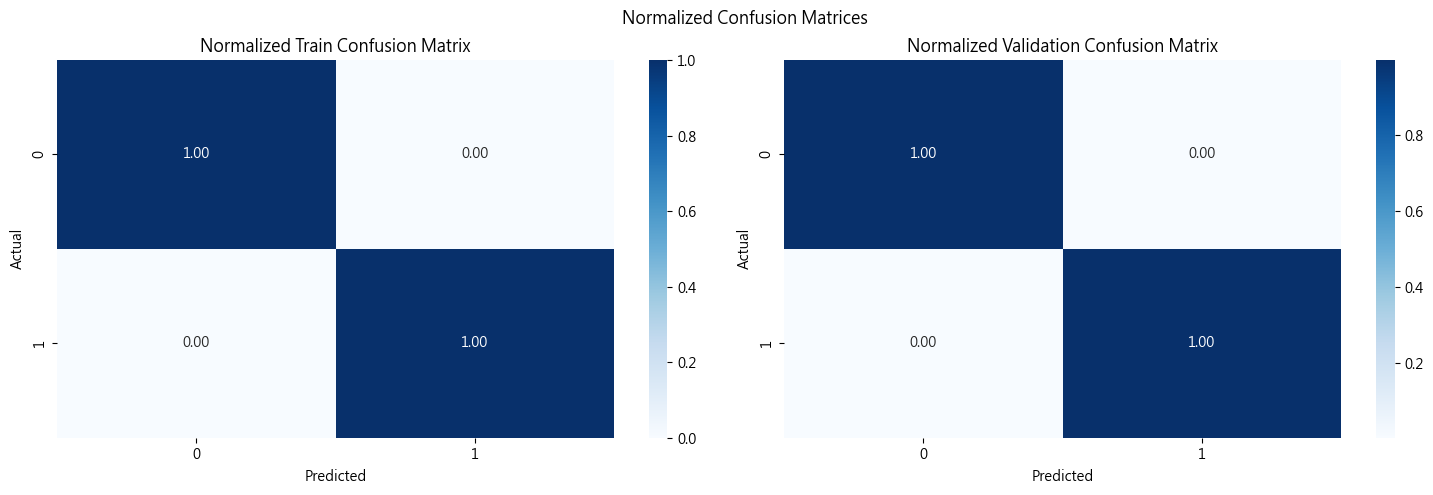

Test F2 Score: 1.0000


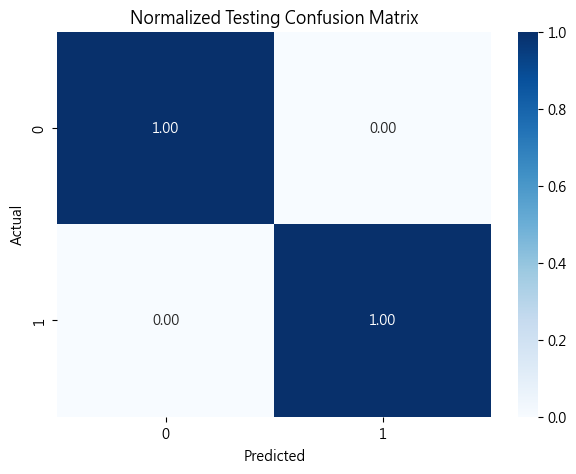

In [7]:
train_mlp_model_with_f2_score(bert_selftrain_train_data, bert_selftrain_test_data, '../Data/Model/bert_selftrain_mlp_10fold_model.pth.gz', '../Data/Model/bert_selftrain_10fold_scaler.pkl.gz')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]         787,456
              ReLU-2                 [-1, 1024]               0
            Linear-3                  [-1, 512]         524,800
              ReLU-4                  [-1, 512]               0
            Linear-5                  [-1, 256]         131,328
              ReLU-6                  [-1, 256]               0
            Linear-7                    [-1, 1]             257
           Sigmoid-8                    [-1, 1]               0
Total params: 1,443,841
Trainable params: 1,443,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 5.51
Estimated Total Size (MB): 5.54
----------------------------------------------------------------
Fold [1], Epoch [10/100], Loss: 0.0061

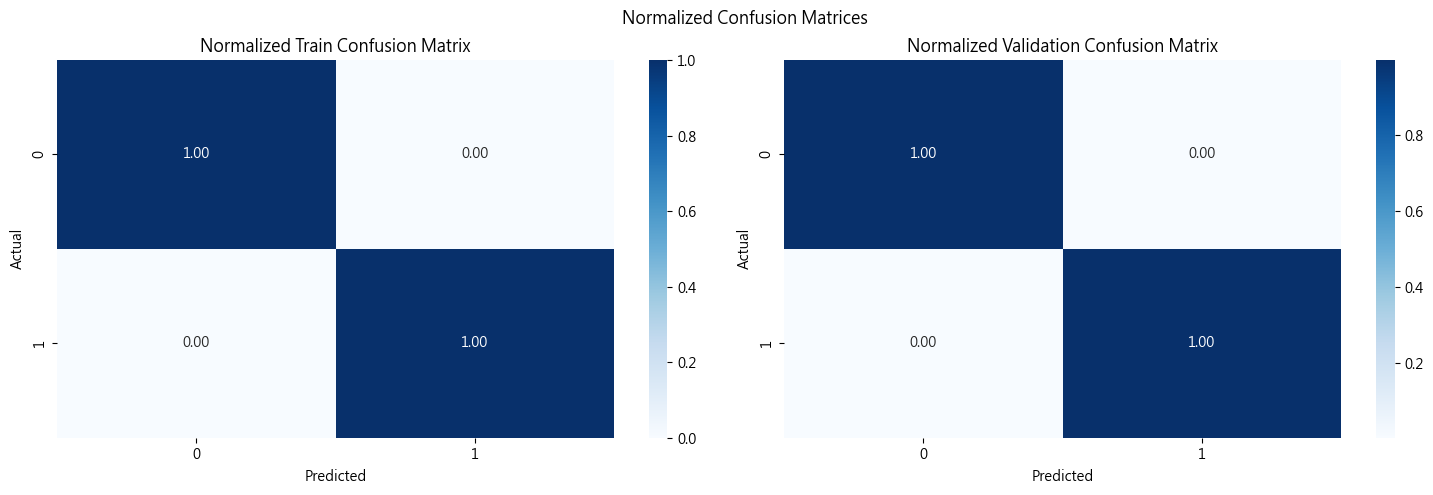

Test F2 Score: 0.9961


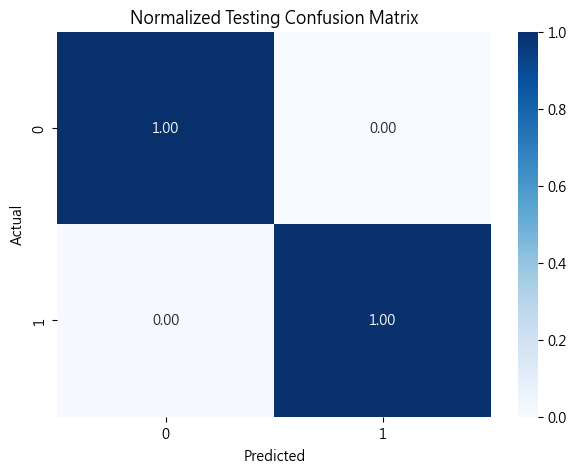

In [8]:
train_mlp_model_with_f2_score(bert_train_data, bert_test_data, '../Data/Model/bert_mlp_10fold_model.pth.gz', '../Data/Model/bert_10fold_scaler.pkl.gz')